In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Load preprocessed data
# Assuming X_bmkg and y_bmkg are already preprocessed
import numpy as np
X_bmkg = np.load("X_bmkg_cnn_bilstm.npy")
y_bmkg = np.load("y_bmkg_cnn_bilstm.npy", allow_pickle=True)

# Verify the shape
print(f"X_bmkg shape: {X_bmkg.shape}")
print(f"y_bmkg shape: {y_bmkg.shape}")


X_bmkg shape: (92883, 5, 10)
y_bmkg shape: (92883, 1)


In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_bmkg, y_bmkg, test_size=0.2, random_state=42)

In [4]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (18577, 5, 10)
y_test shape: (18577, 1)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization,
                                     Bidirectional, LSTM, Dense, Dropout, Attention)

# Input layer
input_layer = Input(shape=(X_bmkg.shape[1], X_bmkg.shape[2]))  # (timesteps, features)

# Feature Extraction Block
conv1 = Conv1D(filters=16, kernel_size=5, strides=1, activation='relu', padding='same')(input_layer)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn1)

conv2 = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(pool1)
bn2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn2)

conv3 = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(pool2)
bn3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn3)

conv4 = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(pool3)
bn4 = BatchNormalization()(conv4)
pool4 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn4)

# Reshape is not required as pool4's output shape is already compatible with LSTM
# Sequence Learning Block
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(pool4)
dropout1 = Dropout(rate=0.2)(lstm1)
lstm2 = Bidirectional(LSTM(units=64, return_sequences=True))(dropout1)
dropout2 = Dropout(rate=0.2)(lstm2)

# Attention Mechanism
attention_output = Attention()([dropout2, dropout2])  # Query = Key = dropout2

# Fully Connected Prediction Block
fc1 = Dense(units=32, activation='relu')(attention_output)
fc2 = Dense(units=10, activation='relu')(fc1)
output_layer = Dense(units=1, activation='linear')(fc2)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [6]:
# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 10)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 5, 16)                816       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 5, 16)                64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 3, 16)                0         ['batch_normalization[0][0

In [7]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=1e-6)

# Train the model
history = model.fit(X_bmkg, y_bmkg,
                    batch_size=64,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/100
1162/1162 [==============================] - 13s 8ms/step - loss: 0.0146 - mae: 0.0958 - val_loss: 0.0137 - val_mae: 0.0931
Epoch 2/100
1162/1162 [==============================] - 8s 7ms/step - loss: 0.0119 - mae: 0.0864 - val_loss: 0.0132 - val_mae: 0.0917
Epoch 3/100
1162/1162 [==============================] - 8s 7ms/step - loss: 0.0109 - mae: 0.0823 - val_loss: 0.0119 - val_mae: 0.0846
Epoch 4/100
1162/1162 [==============================] - 8s 7ms/step - loss: 0.0105 - mae: 0.0805 - val_loss: 0.0112 - val_mae: 0.0821
Epoch 5/100
1162/1162 [==============================] - 8s 7ms/step - loss: 0.0102 - mae: 0.0793 - val_loss: 0.0121 - val_mae: 0.0855
Epoch 6/100
1162/1162 [==============================] - 8s 7ms/step - loss: 0.0100 - mae: 0.0785 - val_loss: 0.0113 - val_mae: 0.0818
Epoch 7/100
1162/1162 [==============================] - 8s 7ms/step - loss: 0.0099 - mae: 0.0780 - val_loss: 0.0111 - val_mae: 0.0819
Epoch 8/100
1162/1162 [==============================]

In [8]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

581/581 [==============================] - 1s 2ms/step - loss: 0.0093 - mae: 0.0752
Test Loss (MSE): 0.0093058617785573
Test MAE: 0.07520165294408798


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Reshape predictions and ground truth for compatibility
y_test_flat = y_test.flatten()  # Flatten if y_test has an extra dimension
y_pred_flat = y_pred.flatten()  # Flatten if y_pred has an extra dimension

# Calculate RMSE
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

# R score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_flat, y_pred_flat)
print(f"R^2 Score: {r2}")


581/581 [==============================] - 1s 1ms/step
Test RMSE: 0.09646691616760734
R^2 Score: 0.36638620127775


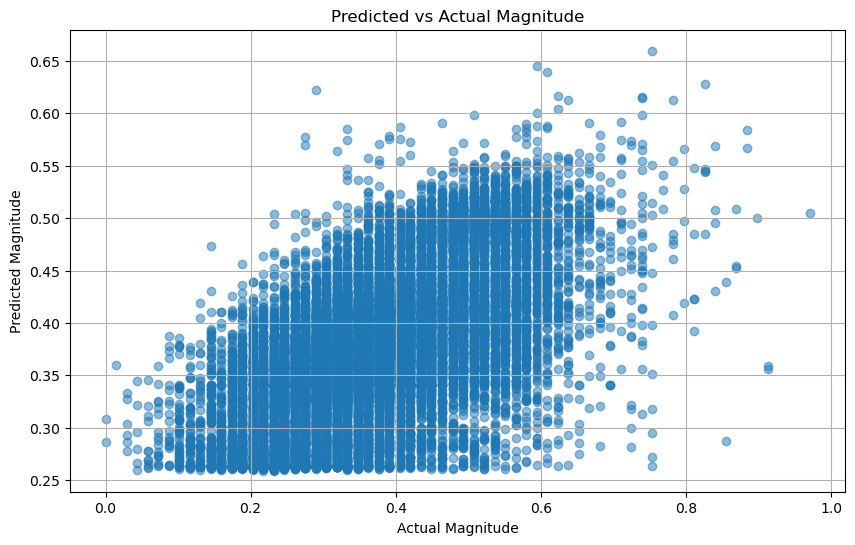

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Predicted vs Actual Magnitude")
plt.grid()
plt.show()


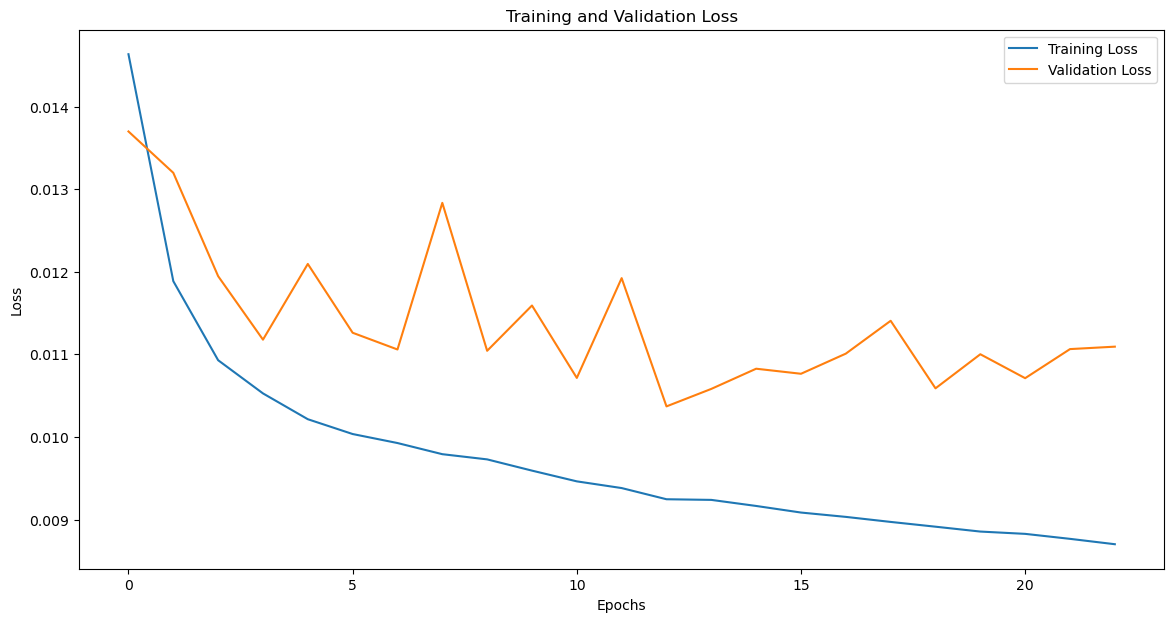

In [11]:
# Plot the training history
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


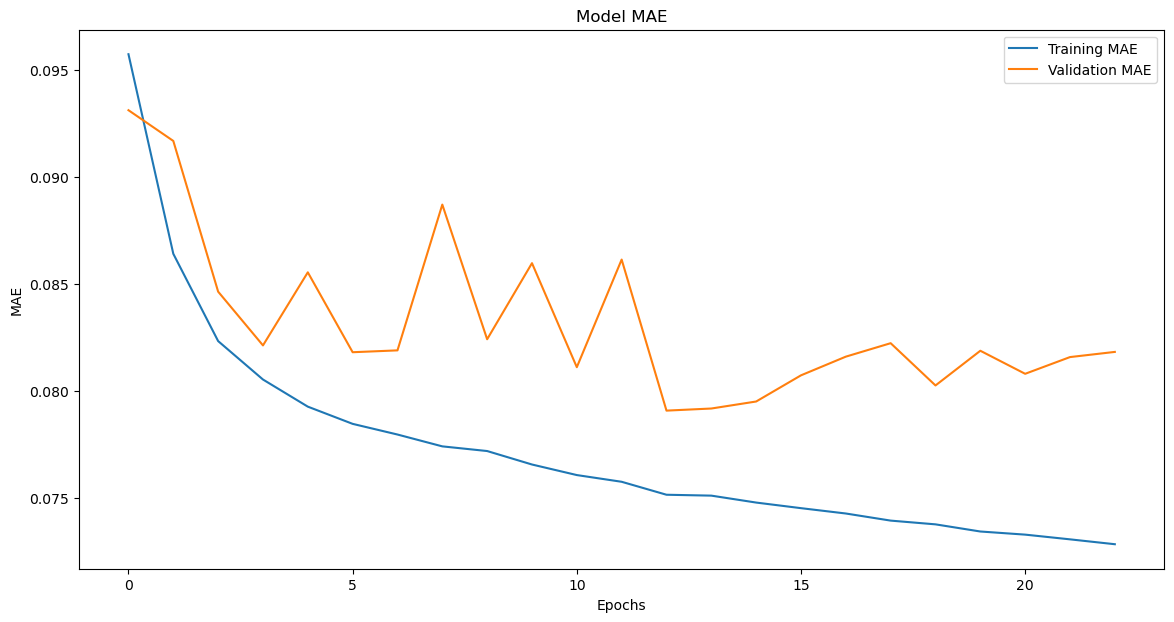

In [12]:
# Plot Training and Validation MAE
plt.figure(figsize=(14, 7))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [20]:
# plot the model preferences
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
# Save the model
model.save("cnn_bilstm_bmkg.h5")

C:\ProgramData\anaconda3\envs\skripsi\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
